In [1]:
#pip install torch torchvision pillow ipywidgets matplotlib numpy ipython
#Version gpu: pip install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu117

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import torch.optim as optim
import os
import random
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

import ipywidgets as widgets
from IPython.display import display
import matplotlib.pyplot as plt
import time


import numpy as np


In [2]:


class PrepareDataSet(Dataset):
    
    def __init__(self, root_dir, split="train", scale_factor=4, patch_size=64, seed=42):
        '''
        Lee las imagenes png del dataset en el root_dir, divide el conjunto en un 80%
        de entrenaimento y el 20% de validación.

        Para cada imagen se tiene su versión en HR (High resolution) y LR(Low resolution)
        El escalado esta diseñado para multiplicar por 4 la resolucion original.
        El entrenamiento será así, si se quiere un escalado a 8, cambiar el parametro pero
        requiere mas gpu y tiempo.

        La semilla es simplemente para poder recrear un entrenamiento.
        El patch_size es el tamaño en pixeles de cada parche HR (en este caso 64x64)
        '''
        self.root_dir = root_dir
        self.scale = scale_factor
        self.patch_size = patch_size
        self.lr_patch = patch_size // scale_factor
        
        all_files = sorted([f for f in os.listdir(root_dir) if f.endswith(".png")])
        random.seed(seed)
        random.shuffle(all_files) #Para aleatoriedad en el entrenamiento y validacion
        split_index = int(0.8 * len(all_files))

        if split == "train":
            self.file_list = all_files[:split_index]
        else:
            self.file_list = all_files[split_index:]

        #Toma un recorte aleatorio del mataño patch_size x patch_size (64x64) de la imagen HR completa
        self.hr_transform = transforms.Compose([transforms.RandomCrop(patch_size),transforms.ToTensor()])

        #Redimensiona bicubicamente el parche HR recortaso a un parche LR de lr_patch x lr_patch (16 x 16)
        self.lr_transform = transforms.Compose([transforms.Resize(self.lr_patch, interpolation=Image.BICUBIC), transforms.ToTensor()])
    
    def __len__(self):
        return len(self.file_list)
    
    
    def __getitem__(self, idx): #No se usa explicitamente pero es ocupado para iterar sobre el dataset
        '''
        Encuentra la imagen en el dataset dado idx, toma un corte aleatorio de patch_size x patch_size, se guarda en hr,
        y del anterior hr se genera su version en lr, guardandolo en lr.

        Retorna:
            Un diccionario con dos claves:

            "lr": tensor de baja resolución ([3, lr_patch, lr_patch]).

            "hr": tensor de alta resolución ([3, patch_size, patch_size]).
        '''
        img_name = self.file_list[idx]
        hr_path = os.path.join(self.root_dir, img_name)
        hr_image = Image.open(hr_path).convert("RGB") #necesitamos rgn
        
        hr_patch = self.hr_transform(hr_image)
        lr_patch = self.lr_transform(transforms.ToPILImage()(hr_patch))
        
        return {"lr": lr_patch, "hr": hr_patch}

#Lectura, carga y preparacion del dataset
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dataset_root = "Flickr2K"

train_dataset = PrepareDataSet(root_dir=dataset_root, split="train", scale_factor=4, patch_size=128)
val_dataset   = PrepareDataSet(root_dir=dataset_root, split="val",   scale_factor=4, patch_size=128)

#Ajustar el batch_size dependiendo de la gpu, el mio con 10 ya ocupa toda la VRAM de la gpu
#El numero de workers afecta a la cpu, tengo 8 nuecleos, asi que pongo 4 workers
train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True,  num_workers=4, pin_memory=True) # en entrenamiento mezclar el orden de los parches cada epoca nueva
val_loader   = DataLoader(val_dataset,   batch_size=10, shuffle=False, num_workers=4, pin_memory=True) #pin memory true pues  hago uso de gpu, tenerlo en true usando cpu no tiene mucho sentido

batch = next(iter(train_loader)) #toma el siguiente mini batch del train loader
lr_batch = batch["lr"].to(device, non_blocking=True) #[10, 3, 32, 32]
hr_batch = batch["hr"].to(device, non_blocking=True) #[10, 3, 128, 128]

#print("LR tamaño de batch:", lr_batch.shape, "Device:")
#print("HR tamaño de batch:", hr_batch.shape, "Device:")
print("Device: ", device)


Device:  cuda


Estructura a modelar, cumplirá la funcion de Generador en el modelo.

![Estructura RRDB](./resources/RRDB.png)

In [3]:
class ResidualDenseBlock(nn.Module):
    def __init__(self, in_channels, growth_channels=32):
        '''
        Realiza 5 convoluciones en cadena, todos con un kernel de 3x3, stride de 1, y padding de 1.
        Parametros:
            grow_channels: cuantos filtros produce cada convolucion
            in_channels: numero de canales por entrada
        '''
        super(ResidualDenseBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, growth_channels, 3, 1, 1)
        self.conv2 = nn.Conv2d(in_channels + growth_channels, growth_channels, 3, 1, 1) #recibe concatenacion de entrada original + salida de conv1
        self.conv3 = nn.Conv2d(in_channels + 2*growth_channels, growth_channels, 3, 1, 1) #recibe entrada original + salida de conv2, etc.
        self.conv4 = nn.Conv2d(in_channels + 3*growth_channels, growth_channels, 3, 1, 1)
        self.conv5 = nn.Conv2d(in_channels + 4*growth_channels, in_channels, 3, 1, 1)
        self.lrelu = nn.LeakyReLU(0.2, inplace=True) #Funcion de activacion
        self.scale = 0.2 #Estabilizar el entrenamiento, para que la contribucion sea proporcional a la escala

    def forward(self, x):
        '''
        Realiza las convoluciones y les aplica la funcion de acticacion
        '''
        inputs = x
        x1 = self.lrelu(self.conv1(inputs))
        x2 = self.lrelu(self.conv2(torch.cat([inputs, x1], dim=1))) #FUncion cat concatena inputs con x1, analogo para las lineas de abajo
        x3 = self.lrelu(self.conv3(torch.cat([inputs, x1, x2], dim=1)))
        x4 = self.lrelu(self.conv4(torch.cat([inputs, x1, x2, x3], dim=1)))
        x5 = self.conv5(torch.cat([inputs, x1, x2, x3, x4], dim=1))
        return inputs + x5 * self.scale

class RRDB(nn.Module):
    '''
    Agrupa 3 ResidualDenseBlock en serie.
    '''
    def __init__(self, in_channels, growth_channels=32):
        super(RRDB, self).__init__()
        self.rdb1 = ResidualDenseBlock(in_channels, growth_channels)
        self.rdb2 = ResidualDenseBlock(in_channels, growth_channels)
        self.rdb3 = ResidualDenseBlock(in_channels, growth_channels)
        self.scale = 0.2

    def forward(self, x):
        out = self.rdb1(x)
        out = self.rdb2(out)
        out = self.rdb3(out)
        return x + out * self.scale



Estructura del generador

![Estructura RRDB](./resources/Generator.png)

Consideracion: La imagen anterior es el generador de un modelo SRGAN, lo que estamos modelando es un ESRGAN
por lo que debemos quitar las apariciones de la funcion de activacion BatchNorm y reemplazar los bloques por los nuestros (RRDB).

In [ ]:
class RRDBNet(nn.Module):
    '''
    Red de super‐resolución, Funciona como generador en ESRGAN, aumentando la resolución 
    de la imagen de entrada por un factor scale.

    '''
    def __init__(self, in_channels=3, out_channels=3, num_features=64, growth_channels=32, num_blocks=23, scale=4):
        '''
         Parámetros:
                in_channels : Canales de la imagen de entrada (3 para RGB).
                out_channels : Canales de la imagen de salida (3 para RGB).
                num_features : Número de filtros en la capa inicial y en cada bloque RRDB.
                num_blocks : Número de bloques RRDB que componen la “trunk” (p. ej. 23). #El trunk es la red que agrupa los bloques RRDB
                scale : Factor de aumento de resolución.
        '''
        super(RRDBNet, self).__init__()
        self.scale = scale
        self.conv_first = nn.Conv2d(in_channels, num_features, 3, 1, 1)
        
        rrdb_blocks = []
        for _ in range(num_blocks):
            rrdb_blocks.append(RRDB(num_features, growth_channels))

            #rrdb_blocks = [RRDB1, RRDB2, RRDB3, ...]
        self.rrdb_trunk = nn.Sequential(*rrdb_blocks) # Equivale a un forward donde el resultado anterior es usado en el actual
                                                        # x = RRDB1.forward(x), x= RRDB2.forward()
        self.trunk_conv = nn.Conv2d(num_features, num_features, 3, 1, 1)
        

        #subidas de resolucion
        upsampling_layers = []
        for _ in range(int(torch.log2(torch.tensor(scale)).item())): #Log2 para ver que tantas iteraciones se hace, si scale igual a 4, entonces log2 de 4 es 2, se harán 2 iteraciones
            upsampling_layers += [
                nn.Conv2d(num_features, num_features * 4, 3, 1, 1), #kernel=3, stride 1, padding 1.
                nn.PixelShuffle(2),
                nn.LeakyReLU(0.2, inplace=True)
            ]
        self.upsampling = nn.Sequential(*upsampling_layers) #Lista con todas las capas en orden [conv2d, pixelShuffle, leakyRelu, ...] se repiten los 3 log2 veces

        # Final convs
        self.conv_last = nn.Conv2d(num_features, num_features, 3, 1, 1)
        self.conv_out = nn.Conv2d(num_features, out_channels, 3, 1, 1)

        self.lrelu = nn.LeakyReLU(0.2, inplace=True)

    def forward(self, x):
        fea = self.conv_first(x)
        trunk = self.trunk_conv(self.rrdb_trunk(fea))
        fea = fea + trunk
        fea = self.upsampling(fea)
        out = self.lrelu(self.conv_last(fea))
        out = self.conv_out(out)
        return out
    

    

Estructura del discriminador

![Estructura RRDB](./resources/Discriminador.png)

Se mantiene la misma arquitectura, pero en la evaluación se determina qué tan “relativista” es una imagen para decidir si es real o fake.
Se omite la sigmoide en la evaluacion final porque en SRGAN simplemente determina si es real (1) o fake(0).
En su lugar, la última capa es una convolución que devuelve un mapa 2D de logits.

In [4]:
class Discriminator(nn.Module):
    '''
    Esta clase implementa un discriminador que analiza parches de la imagen de alta resolución
    y produce un mapa de salida indicando la probabilidad de “realismo” para cada
    región. 

    Supongamos que pasamos una imagel real (HR) por el discriminador, obtenemos el siguiente tensor.

    [[ 2.0,   0.5 ],
     [ -1.0,  1.0 ]]

     Es un mapa de 2x2.

     Igualmente al pasar la imagen generada (fake) por el discriminador se produce otro mapa 2x2:

     [[ -0.5,  -1.0 ],
    [  0.2,  -2.0 ]]

    El objetivo del discriminador es convertir los logits en probabilidades y comparar con las etiquetas
    (1 para real, 0 para fake)

    Al aplicar sigmoid al real se devuelve (Esto se calcula en el entrenamiento, pero es para ejemplificar):

    [[ 0.8808,  0.6225 ],
      [ 0.2689,  0.7311 ]]

      Cercanos a 1, son reales, 

      Para la imagen fake:

      [[ 0.3775,  0.2689 ],
      [ 0.5498,  0.1192 ]]

      Hay uno con 54% de ser real, lo cual es falso, pues es la imagen fake


      Nota: aqui no se aplica sigmoide ni el BCEWithLogitLoss, es hasta el entrenamiento.
    '''
    def __init__(self, in_channels=3, base_channels=64):
        '''
        in_channels : Número de canales en la imagen de entrada (normalmente 3 para RGB).
        base_channels: Número de filtros en la primera capa convolucional; las capas 
                        posteriores amplían este número progresivamente.
        '''
        super(Discriminator, self).__init__()

        #Conv 3x3, stide 1, padding 1
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels, base_channels, 3, 1, 1),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(base_channels, base_channels, 4, 2, 1),
            nn.BatchNorm2d(base_channels), #batch para cada mini batch calcula la media y varainza de las activaaciones y normaliza a media cero.
            nn.LeakyReLU(0.2, inplace=True) #Despues de normalizar leaky relu para considerar tanto positivos como negativos
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(base_channels, base_channels * 2, 3, 1, 1),
            nn.BatchNorm2d(base_channels * 2),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.layer4 = nn.Sequential(
            nn.Conv2d(base_channels * 2, base_channels * 2, 4, 2, 1),
            nn.BatchNorm2d(base_channels * 2),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.layer5 = nn.Sequential(
            nn.Conv2d(base_channels * 2, base_channels * 4, 3, 1, 1),
            nn.BatchNorm2d(base_channels * 4),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.layer6 = nn.Sequential(
            nn.Conv2d(base_channels * 4, base_channels * 4, 4, 2, 1),
            nn.BatchNorm2d(base_channels * 4),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.layer7 = nn.Sequential(
            nn.Conv2d(base_channels * 4, base_channels * 8, 3, 1, 1),
            nn.BatchNorm2d(base_channels * 8),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.layer8 = nn.Sequential(
            nn.Conv2d(base_channels * 8, base_channels * 8, 4, 2, 1),
            nn.BatchNorm2d(base_channels * 8),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.conv9 = nn.Conv2d(base_channels * 8, 1, 3, 1, 1)

    def forward(self, x):
        x = self.layer1(x)   # [B, 64, H, W]
        x = self.layer2(x)   # [B, 64, H/2, W/2]
        x = self.layer3(x)   # [B, 128, H/2, W/2]
        x = self.layer4(x)   # [B, 128, H/4, W/4]
        x = self.layer5(x)   # [B, 256, H/4, W/4]
        x = self.layer6(x)   # [B, 256, H/8, W/8]
        x = self.layer7(x)   # [B, 512, H/8, W/8]
        x = self.layer8(x)   # [B, 512, H/16, W/16]
        out = self.conv9(x)  # [B, 1, H/16, W/16]
        return out



In [ ]:
#Se especifica "we propose animproved perceptual loss by using the VGG features before activation instead of after activation as in SRGAN."

In [5]:
class VGGFeatureExtractor(nn.Module):
    '''
    En conjunto, este código prepara un módulo que toma una imagen de entrada, 
    la normaliza de ser necesario y la pasa por la VGG19, devolviendo los mapas 
    de características en los índices indicados por layer_ids.
    
    Esos mapas se usarán para calcular la pérdida perceptual comparando 
    características de la imagen generada con las de la imagen real.
    '''
    def __init__(self, layer_ids=[35], use_input_norm=True):
        """
        layer_ids: índices de capas cuyas salidas se usarán (p.ej., capa 35 -> conv5_4).
        use_input_norm: normaliza la entrada con los valores de ImageNet.
        """
        super(VGGFeatureExtractor, self).__init__()
        vgg19 = models.vgg19(pretrained=True).features.to(device).eval()
        
        self.use_input_norm = use_input_norm
        if use_input_norm:
            self.register_buffer('mean', torch.Tensor([0.485, 0.456, 0.406]).view(1,3,1,1)) #Estos son valores estandar en python para normalizar 
            self.register_buffer('std',  torch.Tensor([0.229, 0.224, 0.225]).view(1,3,1,1))
        
        # Construir un módulo que incluya todas las capas hasta la máxima layer_id
        max_id = max(layer_ids)
        self.features = nn.Sequential(*[vgg19[i] for i in range(max_id+1)])
        self.layer_ids = layer_ids

    def forward(self, x):
        if self.use_input_norm:
            x = (x - self.mean) / self.std
        outputs = []
        for idx, layer in enumerate(self.features):
            x = layer(x)
            if idx in self.layer_ids:
                outputs.append(x)
        return outputs

In [6]:

#En un el ESRGAN tradicional no se considera la perdida de color.
#Pero yo percibia que se perdia tras pasar una imagen sobre el modelo ya entrenado.
#Así que decidí extender el entrenamiento para que considere la perdida de color

#Es necesaria la conversion para extraer la informacion de luminencia(Y) y  crominancia (Cb y Cr)
#Al separarlos podemos penalizar errores de color sin afectar la parte de brillo y viceversa
def rgb_to_ycbcr_batch(rgb_tensor: torch.Tensor) -> torch.Tensor:
    """
    Convierte un tensor de forma (B, 3, H, W) en espacio RGB (0..1) 
    a YCbCr (también normalizado en 0..1).


    Utilizamos la conversión estándar:
      Y  =  0.299 R + 0.587 G + 0.114 B
      Cb = -0.168736 R - 0.331264 G + 0.5    B + 0.5
      Cr =  0.5    R - 0.418688 G - 0.081312 B + 0.5
    """
    # forma (B,3,H,W) B imagenes con los 3 colores con una altura H y anchura W
    R = rgb_tensor[:, 0:1, :, :]  #Nada mas nos quedamos con el color rojo
    G = rgb_tensor[:, 1:2, :, :]  #Nada mas nos quedamos con el color verde
    B = rgb_tensor[:, 2:3, :, :]  #Nada mas nos quedamos con el color azul

    Y = 0.299 * R + 0.587 * G + 0.114 * B
    Cb = -0.168736 * R - 0.331264 * G + 0.5 * B + 0.5
    Cr = 0.5 * R - 0.418688 * G - 0.081312 * B + 0.5

    return torch.cat([Y, Cb, Cr], dim=1)  # (B,3,H,W)


In [7]:
#Podemos proceder a definir todas las cosas que vamos a ocupar para el entrenamiento

generator = RRDBNet(
    in_channels=3,
    out_channels=3,
    num_features=64,
    growth_channels=32,
    num_blocks=23,
    scale=4
).to(device)

discriminator = Discriminator(in_channels=3, base_channels=64).to(device)
lr_initial = 5e-5 # 1e-4 las primeras 95 epocas #Se ocupa 5e-5 a partir de la 95 epoca

#Optimizadores adam  con los siguientes parametros es lo usual en ESRGAN
optimizer_G = optim.Adam(generator.parameters(), lr=lr_initial, betas=(0.9, 0.999)) #Optimizador para el generador
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr_initial, betas=(0.9, 0.999)) #Optimizador para el Discrimiandor
pixel_loss = nn.L1Loss().to(device)

vgg_extractor = VGGFeatureExtractor(layer_ids=[35], use_input_norm=True).to(device)

# Función de pérdida perceptual (L1 sobre características) (L2 solo penaliza pero no elimina caracteristicas, L1 penaliza y hace seleccion de caracteristicas)
perceptual_loss = nn.L1Loss().to(device) 
bce_loss = nn.BCEWithLogitsLoss().to(device) #Probabilidades de real y fake por parte del discriminador





/home/jose/miniconda3/envs/pateaAbuelitas/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/jose/miniconda3/envs/pateaAbuelitas/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
num_epochs = 120
start_time = time.time() 

train_pixel_losses = []
train_percep_losses = []
train_adv_losses   = []
train_color_losses = []
val_pixel_losses   = []
val_percep_losses  = []
val_color_losses   = []

for epoch in range(num_epochs):

    epoch_start = time.time()  

    #Ponerlos en modo entrenamiento
    generator.train()
    discriminator.train()

    epoch_train_pixel = 0.0
    epoch_train_percep = 0.0
    epoch_train_adv   = 0.0
    epoch_train_color = 0.0
    train_batches = 0
    
    for i, batch in enumerate(train_loader):

        # Mover LR y HR a GPU
        lr = batch["lr"].to(device, non_blocking=True)
        hr = batch["hr"].to(device, non_blocking=True)
        
        #Generamos imagen fake
        with torch.no_grad():
            fake_hr = generator(lr)
        
        #Calculamos probabilidad de que sea real o fake
        #==============Discriminador=========
        pred_real = discriminator(hr)
        pred_fake = discriminator(fake_hr.detach())
        
        real_tensor = torch.ones_like(pred_real, device=device) #Imagenes reales
        fake_tensor = torch.zeros_like(pred_fake, device=device) #Imagenes falsas
        
        #Error del discriminador
        loss_D_real = bce_loss(pred_real, real_tensor)
        loss_D_fake = bce_loss(pred_fake, fake_tensor)
        loss_D = 0.5 * (loss_D_real + loss_D_fake)
        
        #Actualizar pesos del Discriminador
        optimizer_D.zero_grad()
        loss_D.backward()
        optimizer_D.step()
        
        # ============Generador=============
        fake_hr = generator(lr)

        #Engañar a D haciéndole creer que fake_hr es real. Generar etiquetas de “unos” (real_tensor_G) y comparar con la predicción de D.
        pred_fake_for_G = discriminator(fake_hr)
        real_tensor_G = torch.ones_like(pred_fake_for_G, device=device)
        loss_G_adv = bce_loss(pred_fake_for_G, real_tensor_G) #si D cree que fake_hr es real, loss_G_adv baja, haciendo que G genere más realistas
        
        #Perdida de pixel
        loss_pixel = pixel_loss(fake_hr, hr)

        #Perdida perceptual
        feats_fake = vgg_extractor(fake_hr)[0]
        feats_real = vgg_extractor(hr)[0]
        loss_percep = perceptual_loss(feats_fake, feats_real)

        #Pérdida de color
        ycbcr_fake = rgb_to_ycbcr_batch(fake_hr)
        ycbcr_real = rgb_to_ycbcr_batch(hr)
        loss_cb   = F.l1_loss(ycbcr_fake[:, 1:2, :, :], ycbcr_real[:, 1:2, :, :])
        loss_cr   = F.l1_loss(ycbcr_fake[:, 2:3, :, :], ycbcr_real[:, 2:3, :, :])
        loss_color = loss_cb + loss_cr

        #Parametros de penalizacion y relevancia
        #lambda pizel con 1.5 significa que debe ser muy fiel a los pixeles
        #lambda adv determina cuanto debe de engañar G a D, dependiendo de este, en las imagnees finales se pueden generar artefactos.
        #Color asegura fidelidad en cuanto a color
        
        lambda_pixel = 1.5 #1 en un principio
        lambda_percep = 1.2 #1 en un principip
        lambda_adv = 0.008 #0.005 en un principio
        lambda_color  = 0.02 #

        #Perdida general
        loss_G = lambda_pixel * loss_pixel + lambda_percep * loss_percep + lambda_adv * loss_G_adv + lambda_color  * loss_color

        
        #Actualizar pesos del generador
        optimizer_G.zero_grad()
        loss_G.backward()
        optimizer_G.step()

        epoch_train_pixel += loss_pixel.item()
        epoch_train_percep += loss_percep.item()
        epoch_train_adv   += loss_G_adv.item()
        epoch_train_color += loss_color.item()
        train_batches += 1



    train_pixel_losses.append(epoch_train_pixel / train_batches)
    train_percep_losses.append(epoch_train_percep / train_batches)
    train_adv_losses.append(epoch_train_adv / train_batches)
    train_color_losses.append(epoch_train_color / train_batches)

    #=======================Validacion en cada epoca
    generator.eval()
    with torch.no_grad():
        val_pixel_loss = 0.0
        val_percep_loss = 0.0
        val_color_loss  = 0.0
        count = 0
        
        for batch_val in val_loader:
            lr_val = batch_val["lr"].to(device, non_blocking=True)
            hr_val = batch_val["hr"].to(device, non_blocking=True)
            fake_hr_val = generator(lr_val)
            
            #perdida perceptual
            val_pixel_loss += pixel_loss(fake_hr_val, hr_val).item()
            feats_fake_val = vgg_extractor(fake_hr_val)[0]
            feats_real_val = vgg_extractor(hr_val)[0]
            val_percep_loss += perceptual_loss(feats_fake_val, feats_real_val).item()
            
            #Perdida de color
            ycbcr_fake_val = rgb_to_ycbcr_batch(fake_hr_val)
            ycbcr_real_val = rgb_to_ycbcr_batch(hr_val)
            cb_l = F.l1_loss(ycbcr_fake_val[:, 1:2, :, :], ycbcr_real_val[:, 1:2, :, :])
            cr_l = F.l1_loss(ycbcr_fake_val[:, 2:3, :, :], ycbcr_real_val[:, 2:3, :, :])
            val_color_loss += (cb_l + cr_l).item()

            count += 1
        
        val_pixel_loss /= count
        val_percep_loss /= count
        val_color_loss  /= count
        val_pixel_losses.append(val_pixel_loss)
        val_percep_losses.append(val_percep_loss)
        val_color_losses.append(val_color_loss)
        
        epoch_time = time.time() - epoch_start
        print(
            f"Epoch [{epoch+1}/{num_epochs}], "
            f"Pixel: {val_pixel_loss:.4f}, "
            f"Percep: {val_percep_loss:.4f}, "
            f"Color: {val_color_loss:.4f}, "
            f"Tiempo de época: {time.time() - epoch_start:.1f}s"
        )
    
    # ==============Guardar un Checkpoint ==============================
    # Hubo como 3 ocasiones en que estaba lluviendo y se me fue la luz, interrumpiendo el entrenamiento.
    #Pero pude recuperar el entrenamiento.
    if (epoch + 1) % 5 == 0:
        checkpoint = {
            'epoch': epoch + 1,
            'G_state_dict': generator.state_dict(),
            'D_state_dict': discriminator.state_dict(),
            'optimizer_G': optimizer_G.state_dict(),
            'optimizer_D': optimizer_D.state_dict()
        }
        torch.save(checkpoint, f'checkpoint_epoch_{epoch+1}.pth')

total_time = time.time() - start_time
print(f"Entrenamiento completado en {total_time:.1f}s ({total_time/60:.1f} minutos).")

#Con un I511400H 6 nucleos 12 hilos y una rtx 3050 vram (laptop)
#Tomó 5 minutos por cada epoca
#Tomando un total de 12.5 horas de entrenamiento


Epoch [1/120], Pixel: 0.0627, Percep: 0.1315, Color: 0.0551, Tiempo de época: 184.0s
Epoch [2/120], Pixel: 0.0592, Percep: 0.1376, Color: 0.0526, Tiempo de época: 186.1s
Epoch [3/120], Pixel: 0.0532, Percep: 0.1291, Color: 0.0480, Tiempo de época: 187.6s
Epoch [4/120], Pixel: 0.0492, Percep: 0.1256, Color: 0.0391, Tiempo de época: 188.3s
Epoch [5/120], Pixel: 0.0519, Percep: 0.1324, Color: 0.0415, Tiempo de época: 188.7s
Epoch [6/120], Pixel: 0.0517, Percep: 0.1288, Color: 0.0386, Tiempo de época: 189.6s
Epoch [7/120], Pixel: 0.0467, Percep: 0.1215, Color: 0.0354, Tiempo de época: 189.5s
Epoch [8/120], Pixel: 0.0494, Percep: 0.1221, Color: 0.0332, Tiempo de época: 189.9s
Epoch [9/120], Pixel: 0.0445, Percep: 0.1200, Color: 0.0282, Tiempo de época: 190.1s
Epoch [10/120], Pixel: 0.0465, Percep: 0.1254, Color: 0.0316, Tiempo de época: 190.3s
Epoch [11/120], Pixel: 0.0461, Percep: 0.1247, Color: 0.0299, Tiempo de época: 190.3s
Epoch [12/120], Pixel: 0.0466, Percep: 0.1233, Color: 0.0276, T

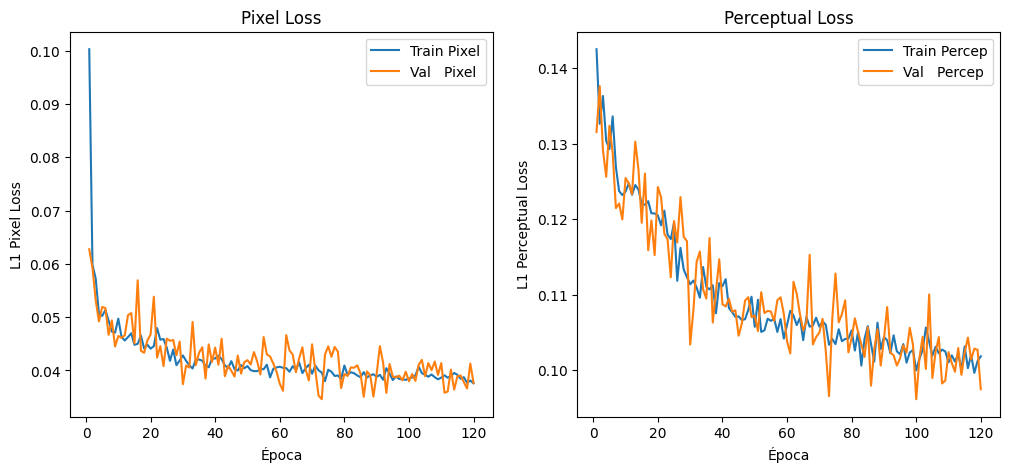

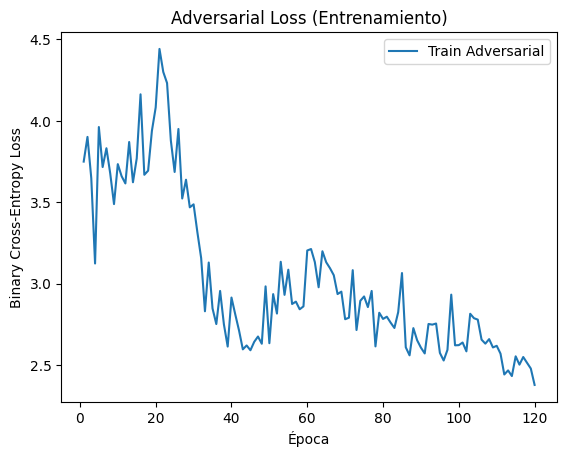

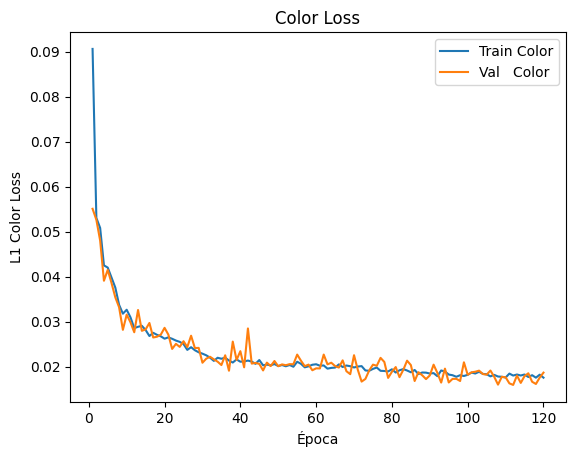

In [10]:
epochs = list(range(1, num_epochs + 1))

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_pixel_losses, label="Train Pixel")
plt.plot(epochs, val_pixel_losses,   label="Val   Pixel")
plt.xlabel("Época")
plt.ylabel("L1 Pixel Loss")
plt.legend()
plt.title("Pixel Loss")

plt.subplot(1, 2, 2)
plt.plot(epochs, train_percep_losses, label="Train Percep")
plt.plot(epochs, val_percep_losses,   label="Val   Percep")
plt.xlabel("Época")
plt.ylabel("L1 Perceptual Loss")
plt.legend()
plt.title("Perceptual Loss")

plt.figure()
plt.plot(epochs, train_adv_losses, label="Train Adversarial")
plt.xlabel("Época")
plt.ylabel("Binary Cross-Entropy Loss")
plt.legend()
plt.title("Adversarial Loss (Entrenamiento)")
plt.show()

plt.figure()
plt.plot(epochs, train_color_losses, label="Train Color")
plt.plot(epochs, val_color_losses,   label="Val   Color")
plt.xlabel("Época")
plt.ylabel("L1 Color Loss")
plt.legend()
plt.title("Color Loss")
plt.show()



In [ ]:

#Esto es solo para continuar entrenamiento a partir de un checkpoint, se me fue la luz en un momento y pude continuar
#Se tienen que volver a correr todas las celdas anteriores al de arriba.


checkpoint = torch.load("checkpoint_epoch_120.pth", map_location=device)
generator.load_state_dict(checkpoint["G_state_dict"])
discriminator.load_state_dict(checkpoint["D_state_dict"])
optimizer_G.load_state_dict(checkpoint["optimizer_G"])
optimizer_D.load_state_dict(checkpoint["optimizer_D"])




In [ ]:

#Esto es solo para continuar entrenamiento a partir de un checkpoint, se me fue la luz en un momento y pude continuar
#Se tienen que volver a correr todas las celdas anteriores al de arriba.


checkpoint = torch.load("checkpoint_epoch_120.pth", map_location=device)
generator.load_state_dict(checkpoint["G_state_dict"])
discriminator.load_state_dict(checkpoint["D_state_dict"])
optimizer_G.load_state_dict(checkpoint["optimizer_G"])
optimizer_D.load_state_dict(checkpoint["optimizer_D"])




In [ ]:

#Esto es solo para continuar entrenamiento a partir de un checkpoint, se me fue la luz en un momento y pude continuar
#Se tienen que volver a correr todas las celdas anteriores al de arriba.


checkpoint = torch.load("checkpoint_epoch_120.pth", map_location=device)
generator.load_state_dict(checkpoint["G_state_dict"])
discriminator.load_state_dict(checkpoint["D_state_dict"])
optimizer_G.load_state_dict(checkpoint["optimizer_G"])
optimizer_D.load_state_dict(checkpoint["optimizer_D"])




In [9]:
#Entrenamiento para continuar a partir de una epoca.
#Se puede generalizar para no repetir tanto codigo, pero ya no me dio tiempo


start_epoch = checkpoint["epoch"]
num_epochs = 210

start_time = time.time()

for epoch in range(start_epoch, num_epochs+1):
    epoch_start = time.time()
    generator.train()
    discriminator.train()

    for i, batch in enumerate(train_loader):
        lr = batch["lr"].to(device, non_blocking=True)
        hr = batch["hr"].to(device, non_blocking=True)

        with torch.no_grad():
            fake_hr = generator(lr)

        pred_real = discriminator(hr)
        pred_fake = discriminator(fake_hr.detach())

        real_tensor = torch.ones_like(pred_real, device=device)
        fake_tensor = torch.zeros_like(pred_fake, device=device)

        loss_D_real = bce_loss(pred_real, real_tensor)
        loss_D_fake = bce_loss(pred_fake, fake_tensor)
        loss_D = 0.5 * (loss_D_real + loss_D_fake)

        optimizer_D.zero_grad()
        loss_D.backward()
        optimizer_D.step()

        fake_hr = generator(lr)
        pred_fake_for_G = discriminator(fake_hr)

        real_tensor_G = torch.ones_like(pred_fake_for_G, device=device)
        loss_G_adv = bce_loss(pred_fake_for_G, real_tensor_G)

        loss_pixel = pixel_loss(fake_hr, hr)

        feats_fake = vgg_extractor(fake_hr)[0]
        feats_real = vgg_extractor(hr)[0]
        loss_percep = perceptual_loss(feats_fake, feats_real)

        ycbcr_fake = rgb_to_ycbcr_batch(fake_hr)
        ycbcr_real = rgb_to_ycbcr_batch(hr)
        loss_cb = F.l1_loss(ycbcr_fake[:, 1:2, :, :], ycbcr_real[:, 1:2, :, :])
        loss_cr = F.l1_loss(ycbcr_fake[:, 2:3, :, :], ycbcr_real[:, 2:3, :, :])
        loss_color = loss_cb + loss_cr

        lambda_pixel = 1.5 #1 en un principio
        lambda_percep = 1.2 #1 en un principip
        lambda_adv = 0.01 #0.005 en un principio
        lambda_color  = 0.02 #

        loss_G = (
            lambda_pixel * loss_pixel
            + lambda_percep * loss_percep
            + lambda_adv * loss_G_adv
            + lambda_color * loss_color
        )

        optimizer_G.zero_grad()
        loss_G.backward()
        optimizer_G.step()

        # Imprimir métricas cada 100 iteraciones
        if (i + 1) % 100 == 0:
            elapsed_iter = time.time() - epoch_start
            print(
                f"Epoch [{epoch}/{num_epochs}], Step [{i+1}/{len(train_loader)}], "
                f"Loss_D: {loss_D.item():.4f}, Loss_G: {loss_G.item():.4f}, "
                f"Pixel: {loss_pixel.item():.4f}, Percep: {loss_percep.item():.4f}, "
                f"Adv: {loss_G_adv.item():.4f}, Color: {loss_color.item():.4f}, "
                f"Tiempo iter: {elapsed_iter:.1f}s"
            )

    generator.eval()
    with torch.no_grad():
        val_pixel_loss = 0.0
        val_percep_loss = 0.0
        val_color_loss = 0.0
        count = 0

        for batch_val in val_loader:
            lr_val = batch_val["lr"].to(device, non_blocking=True)
            hr_val = batch_val["hr"].to(device, non_blocking=True)
            fake_hr_val = generator(lr_val)

            val_pixel_loss += pixel_loss(fake_hr_val, hr_val).item()

            feats_fake_val = vgg_extractor(fake_hr_val)[0]
            feats_real_val = vgg_extractor(hr_val)[0]
            val_percep_loss += perceptual_loss(feats_fake_val, feats_real_val).item()

            ycbcr_fake_val = rgb_to_ycbcr_batch(fake_hr_val)
            ycbcr_real_val = rgb_to_ycbcr_batch(hr_val)
            cb_l = F.l1_loss(ycbcr_fake_val[:, 1:2, :, :], ycbcr_real_val[:, 1:2, :, :])
            cr_l = F.l1_loss(ycbcr_fake_val[:, 2:3, :, :], ycbcr_real_val[:, 2:3, :, :])
            val_color_loss += (cb_l + cr_l).item()

            count += 1

        val_pixel_loss /= count
        val_percep_loss /= count
        val_color_loss /= count

        epoch_time = time.time() - epoch_start
        print(
            f"Epoch [{epoch}/{num_epochs}], Step [{i+1}/{len(train_loader)}], "
            f"Loss_D: {loss_D.item():.4f}, Loss_G: {loss_G.item():.4f}, "
            f"Pixel: {loss_pixel.item():.4f}, Percep: {loss_percep.item():.4f}, "
            f"Adv: {loss_G_adv.item():.4f}, Color: {loss_color.item():.4f}, "
            f"Tiempo: {elapsed_iter:.1f}s"
    
        )

    if epoch % 5 == 0:
        checkpoint = {
            "epoch": epoch,
            "G_state_dict": generator.state_dict(),
            "D_state_dict": discriminator.state_dict(),
            "optimizer_G": optimizer_G.state_dict(),
            "optimizer_D": optimizer_D.state_dict(),
        }
        torch.save(checkpoint, f"checkpoint_epoch_{epoch}.pth")

total_time = time.time() - start_time
print(f"Entrenamiento completado en {total_time:.1f}s ({total_time/60:.1f} minutos).")


#Con un I511400H 6 nucleos 12 hilos y una rtx 3050 vram (laptop)
#Tomó 5 minutos por cada epoca
#Tomando un total de 12.5 horas de entrenamiento




Epoch [120/210], Step [100/212], Loss_D: 0.1036, Loss_G: 0.2505, Pixel: 0.0413, Percep: 0.1377, Adv: 2.2878, Color: 0.0202, Tiempo iter: 86.0s
Epoch [120/210], Step [200/212], Loss_D: 0.4081, Loss_G: 0.2138, Pixel: 0.0533, Percep: 0.1025, Adv: 1.0311, Color: 0.0234, Tiempo iter: 175.6s
Epoch [120/210], Step [212/212], Loss_D: 0.5575, Loss_G: 0.1769, Pixel: 0.0275, Percep: 0.1014, Adv: 1.3571, Color: 0.0126, Tiempo: 175.6s
Epoch [121/210], Step [100/212], Loss_D: 0.1046, Loss_G: 0.2054, Pixel: 0.0303, Percep: 0.1099, Adv: 2.7702, Color: 0.0171, Tiempo iter: 88.1s
Epoch [121/210], Step [200/212], Loss_D: 0.2307, Loss_G: 0.2209, Pixel: 0.0402, Percep: 0.1019, Adv: 3.8006, Color: 0.0207, Tiempo iter: 176.6s
Epoch [121/210], Step [212/212], Loss_D: 1.0716, Loss_G: 0.1902, Pixel: 0.0233, Percep: 0.1028, Adv: 3.1658, Color: 0.0132, Tiempo: 176.6s
Epoch [122/210], Step [100/212], Loss_D: 0.6470, Loss_G: 0.1865, Pixel: 0.0238, Percep: 0.0994, Adv: 3.1280, Color: 0.0146, Tiempo iter: 89.6s
Epoch

In [14]:
'''EJECUTAR ESTO SOLO SI SE QUIERE APLICAR LA SUPER RESOLUCION A PARTIR DE UN CHECKPOINT'''
ckpt = torch.load('checkpoint_epoch_70.pth', map_location=device)
generator.load_state_dict(ckpt['G_state_dict'])
generator.eval()

/tmp/ipykernel_65913/1456583334.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load('checkpoint_epoch_70.pth', map_location=device)


RRDBNet(
  (conv_first): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (rrdb_trunk): Sequential(
    (0): RRDB(
      (rdb1): ResidualDenseBlock(
        (conv1): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv2): Conv2d(96, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv3): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv4): Conv2d(160, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv5): Conv2d(192, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (lrelu): LeakyReLU(negative_slope=0.2, inplace=True)
      )
      (rdb2): ResidualDenseBlock(
        (conv1): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv2): Conv2d(96, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv3): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv4): Conv2d(160, 32, kernel_size=(3, 3), stride=(1

In [11]:



def super_resolve_image(model,img_path,device,scale=4,tile_size=256,overlap=32):
    """
    Aplica la super resolucion a partir de un modelo ya entrenado

    Parametros:
        model: El modelo RRDBNet Entrenado.
        img_path: Direccion a la imagen que se le aplicará el escalado.
        device: Se ocupara para realizar el trabajo (cpu o gpu).
        scale: Factor de escalado, el modelo actual solo soporta 4 como input.
        tile_size: Tamaño de cada mosaico que se procesa de manera independiente.
        overlap: Longitud de cada mosaico para que se extienda sobre otro, sirve para evitar bordes visibles y tener una continuidad de texturas.

    """

    #Poner el modelo en modo evaluacion
    model.eval()
    lr_image = Image.open(img_path).convert("RGB")
    lr_np = np.array(lr_image).astype(np.float32) / 255.0  # Convertir en un array 
    h_lr, w_lr, _ = lr_np.shape #alto y largo
    h_hr, w_hr = h_lr * scale, w_lr * scale  # Dimensiones de salida

    # Arrays de output para acumular las sumas de piexeles y el overlapping
    output_sum = np.zeros((h_hr, w_hr, 3), dtype=np.float32)
    count_map = np.zeros((h_hr, w_hr, 3), dtype=np.float32)

    def process_tile(x0, y0, x1, y1):
        '''
        Recorta un mosaico de la imagen LR, lo procesa con el modelo y devuelve el
        mosaico HR resultante como arreglo NumPy en [0,1].

        Parametros:
            x0, y0: Coordenadas de la esquina superior izquierda del mosaico en LR.
            x1, y1: Coordenadas de la esquina inferior derecha del mosaico en LR.

        '''
        lr_tile = lr_np[y0:y1, x0:x1, :]
        # Convierte a tensor con forma [1, 3, H, W]
        lr_tensor = torch.from_numpy(lr_tile.transpose(2, 0, 1)).unsqueeze(0).to(device)
        with torch.no_grad():
            sr_tensor = model(lr_tensor)

        # Convierte el tensor de salida a NumPy en (H*scale, W*scale, 3)
        
        sr_np = sr_tensor.squeeze(0).clamp(0, 1).cpu().numpy().transpose(1, 2, 0)
        return sr_np

    # La distancia que avanzamos en LR para cada mosaico
    stride = tile_size - overlap
    for y in range(0, h_lr, stride):
        # Recorre coordenadas X de los mosaicos
        for x in range(0, w_lr, stride):
            # Determina bordes del mosaico, sin exceder los límites de la image
            x_end = min(x + tile_size, w_lr)
            y_end = min(y + tile_size, h_lr)
            x0, y0 = x, y
            x1, y1 = x_end, y_end

         
            sr_tile = process_tile(x0, y0, x1, y1)
            # Calcular coordenadas en la version HR
            x0_hr, y0_hr = x0 * scale, y0 * scale
            x1_hr, y1_hr = x1 * scale, y1 * scale

            # Acumula valores de píxeles y actualiza conteo para promediar luego
            output_sum[y0_hr:y1_hr, x0_hr:x1_hr, :] += sr_tile
            count_map[y0_hr:y1_hr, x0_hr:x1_hr, :] += 1.0

    ## Promedia las zonas solapadas dividiendo suma entre conteo
    output_avg = output_sum / count_map
    # Convierte de nuevo a uint8 en [0,255]
    output_img = (output_avg * 255.0).round().astype(np.uint8)
    return Image.fromarray(output_img)




In [13]:
#Uso final
#asegurarse que la imagen existe
lr_input_path = "./images/cc.webp"
sr_output_path = "./scaledImages/ccGrafica.webp"

sr_image = super_resolve_image(
    model=generator,
    img_path=lr_input_path,
    device=device,
    scale=4,
    tile_size=256,
    overlap=32
)

sr_image.save(sr_output_path)
print(f"Imagen escalada x4 guardada en: {sr_output_path}")

Imagen escalada x4 guardada en: ./scaledImages/treeGrafica.jpg


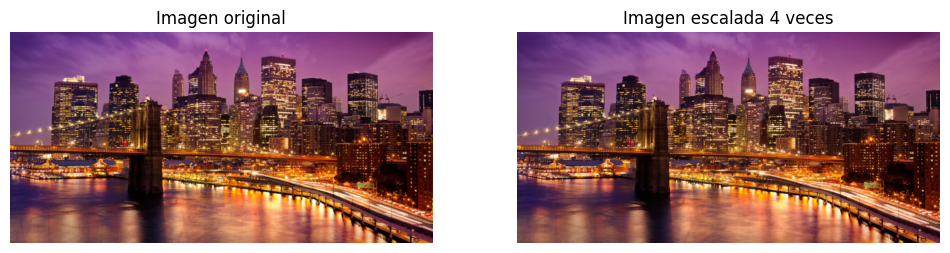

In [15]:
#Comparacion de imagen original e imagen escalada

plt.figure(figsize=(12, 6))
lr_display = Image.open(lr_input_path).convert("RGB").resize(sr_image.size, Image.BICUBIC)
plt.subplot(1, 2, 1)
plt.imshow(lr_display)
plt.title("Imagen original")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(sr_image)
plt.title("Imagen escalada 4 veces")
plt.axis("off")
plt.show()


In [3]:
#Esto es solo para visualizar el dataset
dataset_root = "Flickr2K"
image_files = sorted([f for f in os.listdir(dataset_root) if f.endswith(".png")])

# Función para mostrar la imagen dada la posición
def show_image(idx):
    img_path = os.path.join(dataset_root, image_files[idx])
    img = Image.open(img_path).convert("RGB")
    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Imagen {idx + 1}/{len(image_files)}: {image_files[idx]}")
    plt.show()

# Widget 
slider = widgets.IntSlider(
    value=0,
    min=0,
    max=len(image_files) - 1,
    step=1,
    description='Índice:',
    continuous_update=False
)

widgets.interact(show_image, idx=slider)

interactive(children=(IntSlider(value=0, continuous_update=False, description='Índice:', max=2649), Output()),…

<function __main__.show_image(idx)>

In [ ]:
#Referencias
#https://arxiv.org/pdf/1809.00219
#https://www.freecodecamp.org/news/an-intuitive-introduction-to-generative-adversarial-networks-gans-7a2264a81394
#https://pyimagesearch.com/2022/06/06/super-resolution-generative-adversarial-networks-srgan/